In [1]:
#Using onecycle presented in A DISCIPLINED APPROACH TO NEURAL NETWORK HYPER-PARAMETERS: PART 1 – LEARNING RATE, BATCH SIZE, MOMENTUM, AND WEIGHT DECAY
#https://arxiv.org/pdf/1803.09820.pdf

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train_noise = np.random.uniform(low = 0, high = 0.3, size = x_train.shape)
x_train, x_test = x_train / 255., x_test / 255.
x_train_with_noise = x_train + x_train_noise
x_train, x_valid = x_train[5000:], x_train[:5000]
x_train_with_noise, x_valid_with_noise = x_train_with_noise[5000:], x_train_with_noise[:5000]
y_train, y_valid = y_train[5000:], y_train[:5000]
y_train, y_valid = y_train.astype(np.uint8), y_valid.astype(np.uint8)
x_train = x_train[..., np.newaxis]
x_valid = x_valid[..., np.newaxis]
x_test = x_test[..., np.newaxis]

In [3]:
def scale_data(x_t, x_v):
    means = x_t.mean(axis = 0, keepdims = True)
    stds = x_t.std(axis = 0, keepdims = True)
    x_train_scaled = (x_t - means) / stds
    x_valid_scaled = (x_v - means) / stds
    x_test_scaled = (x_test - means) / stds
    return x_train_scaled, x_valid_scaled, x_test_scaled
x_train_noise_scaled, x_valid_noise_scaled, x_test_noise_scaled = scale_data(x_train_with_noise, x_valid_with_noise)

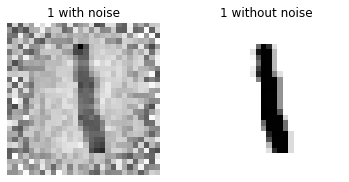

In [4]:
def plot_image(index, x, x1 = None):
    plt.figure(figsize = (6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(x[index], cmap = "binary")
    #plt.title(y_valid[index])
    plt.axis("off")
    plt.title("{} with noise".format(y_valid[index]))
    plt.subplot(1, 2, 2)
    plt.imshow(x1.reshape(x1.shape[0], 28, 28)[index], cmap = "binary")
    plt.axis("off")
    plt.title("{} without noise".format(y_valid[index]))
    plt.show()

plot_image(6, x_valid_noise_scaled, x_valid)

In [5]:
batch_size = 64
n_epochs = 30

def create_model():
    cls = keras.models.Sequential([
        keras.layers.Reshape((28, 28, 1)),
        keras.layers.Conv2D(32, 2, activation = "selu", kernel_initializer = "lecun_normal"),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(64, 2, activation = "selu", kernel_initializer = "lecun_normal"),
        keras.layers.BatchNormalization(),
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation = "selu", kernel_initializer = "lecun_normal"),
        keras.layers.Dropout(0.1),
        keras.layers.Dense(10, activation = "softmax")
    ])
    cls.compile(loss = "sparse_categorical_crossentropy", optimizer = "nadam", metrics = ["accuracy"])
    return cls

In [6]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)
    
def search_lr(model, X, y, epochs = 1, batch_size = batch_size, min_rate = 1e-5, max_rate = 10):
    #init_weights = model.get_weights()
    iterations = len(X) // batch_size * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = cls.fit(X, y, epochs = epochs, batch_size = batch_size, callbacks = [exp_lr])
    K.set_value(model.optimizer.lr, init_lr)
    #model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")
    plt.show()

860/860 [==============================] - 8s 10ms/step - loss: 69.8156 - accuracy: 0.5096: 1s - l


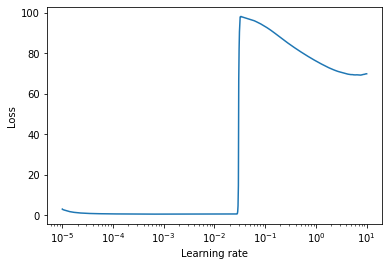

In [7]:
cls = create_model()
rates, losses = search_lr(cls, x_train, y_train, epochs = 1, batch_size = batch_size)
plot_lr_vs_loss(rates, losses)

In [8]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate = None, last_iterations = None, last_rate = None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return (((rate2 - rate1) / (iter2 - iter1)) * (self.iteration - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration, self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations, self.start_rate, self.last_rate)
            rate = max(rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)

In [9]:
onecycle = OneCycleScheduler(len(x_train) // batch_size * n_epochs, max_rate = 1e-2)
cls_no = create_model()
normal_data_onecycle = cls_no.fit(x_train, y_train, batch_size = batch_size, epochs = n_epochs, validation_data = (x_valid, y_valid), callbacks = [onecycle], verbose = 0)

In [10]:
cls_n = create_model()
normal_data = cls_n.fit(x_train, y_train, batch_size = batch_size, epochs = n_epochs, validation_data = (x_valid, y_valid), verbose = 0)

In [11]:
onecycle = OneCycleScheduler(len(x_train) // batch_size * n_epochs, max_rate = 1e-5)
cls_noiseo = create_model()
noise_data_onecycle = cls_noiseo.fit(x_train_noise_scaled, y_train, batch_size = batch_size, epochs = n_epochs, validation_data = (x_valid_noise_scaled, y_valid), callbacks = [onecycle], verbose = 0)

In [12]:
cls_noise = create_model()
noise_data = cls_noise.fit(x_train_noise_scaled, y_train, batch_size = batch_size, epochs = n_epochs, validation_data = (x_valid_noise_scaled, y_valid), verbose = 0)

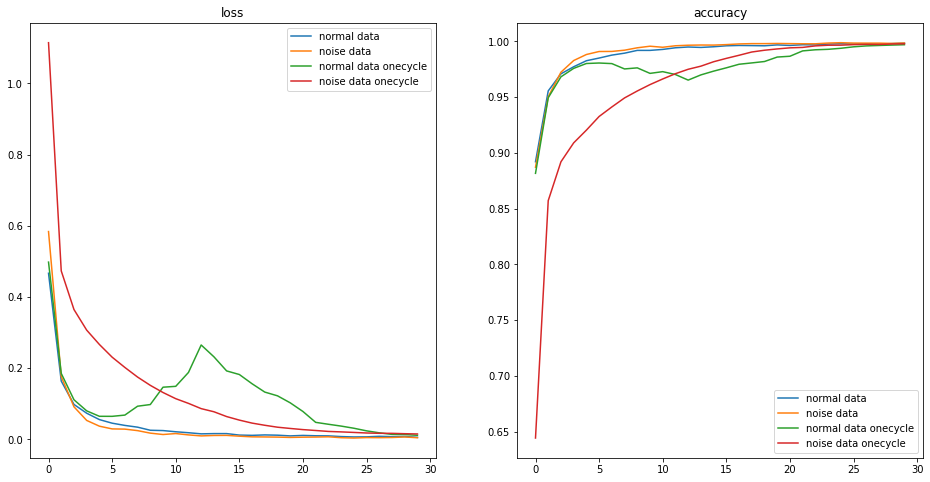

In [13]:
plt.figure(figsize = (16, 8))
plt.subplot(1, 2, 1)
plt.plot(normal_data.history["loss"], label = "normal data")
plt.plot(noise_data.history["loss"], label = "noise data")
plt.plot(normal_data_onecycle.history["loss"], label = "normal data onecycle")
plt.plot(noise_data_onecycle.history["loss"], label = "noise data onecycle")
plt.legend()
plt.title("loss")
plt.subplot(1, 2, 2)
plt.plot(normal_data.history["accuracy"], label = "normal data")
plt.plot(noise_data.history["accuracy"], label = "noise data")
plt.plot(normal_data_onecycle.history["accuracy"], label = "normal data onecycle")
plt.plot(noise_data_onecycle.history["accuracy"], label = "noise data onecycle")
plt.legend()
plt.title("accuracy")
plt.show()

In [14]:
cls_n.evaluate(x_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.1342 - accuracy: 0.9823


[0.1341942846775055, 0.9822999835014343]

In [15]:
cls_no.evaluate(x_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.3073 - accuracy: 0.9817


[0.307331919670105, 0.9817000031471252]

In [16]:
cls_noise.evaluate(x_test, y_test) #overfitting

313/313 [==============================] - 1s 3ms/step - loss: 3.7983 - accuracy: 0.1185


[3.798257827758789, 0.1185000017285347]

In [17]:
cls_noiseo.evaluate(x_test, y_test) #overfitting

313/313 [==============================] - 1s 3ms/step - loss: 4.4051 - accuracy: 0.2254


[4.405086517333984, 0.22540000081062317]

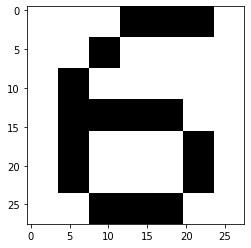

In [34]:
image = [[0, 0, 0, 1, 1, 1, 0],
         [0, 0, 1, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0, 0],
         [0, 1, 1, 1, 1, 0, 0],
         [0, 1, 0, 0, 0, 1, 0],
         [0, 1, 0, 0, 0, 1, 0],
         [0, 0, 1, 1, 1, 0, 0],]

image1 = np.concatenate([np.concatenate([[x] * 4 for x in y] * 4) for y in image])
plt.imshow(image1.reshape(28, 28), cmap = "binary")

In [36]:
image1 = image1.reshape(28, 28)
image1 = image1[..., np.newaxis]
print(np.argmax(cls_n.predict(image1.reshape(1, -1))))

6
